In [289]:
import pandas as pd  
import numpy as np  
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [290]:
picks = pd.read_parquet('../../Data/Historical_Picks_by_Week.parquet')
matchups = pd.read_parquet('../../Data/Historical_Player_Performance_Final.parquet')

In [291]:
matchups.head()

,season,week,owner,starter_fantasy_points,starter_fp_lag_1,starter_fp_lag_2,starter_fp_lag_3,starter_fp_lag_4,starter_fp_4wk_avg_lag1,starter_fp_8wk_avg_lag1,starter_fp_4wk_std_lag1,weekly_win_lag_1,weekly_loss_lag_1,weekly_tie_lag_1,weekly_win_lag_2,weekly_loss_lag_2,weekly_tie_lag_2,weekly_win_lag_3,weekly_loss_lag_3,weekly_tie_lag_3,weekly_win_lag_4,weekly_loss_lag_4,weekly_tie_lag_4,win_pct_4wk_lag1,cum_wins_lag_1,cum_losses_lag_1,win_pct_lag_1,cum_wins_lag_2,cum_losses_lag_2,win_pct_lag_2,cum_wins_lag_3,cum_losses_lag_3,win_pct_lag_3,cum_wins_lag_4,cum_losses_lag_4,win_pct_lag_4,win_pct_change_1wk,cum_wins_change_1wk,cum_points_lag_1,season_rank_lag_1,cum_points_lag_2,season_rank_lag_2,cum_points_lag_3,season_rank_lag_3,cum_points_lag_4,season_rank_lag_4,cum_points_4wk_avg_lag1
0,2023,1,Brigido,150.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,2,Brigido,167.54,150.14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,150.14,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,3,Brigido,177.62,167.54,150.14,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,317.68,1.0,150.14,2.0,NaN,NaN,NaN,NaN,NaN
3,2023,4,Brigido,146.80,177.62,167.54,150.14,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,3.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,0.0,1.0,495.30,1.0,317.68,1.0,150.14,2.0,NaN,NaN,NaN
4,2023,5,Brigido,131.06,146.80,177.62,167.54,150.14,160.525,NaN,14.579359,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,-0.2,0.0,642.10,2.0,495.30,1.0,317.68,1.0,150.14,2.0,401.305


In [292]:
picks.shape

(510, 31)

In [293]:
matchups.shape

(510, 47)

In [294]:
train = picks.merge(matchups, 
                         how = 'left',
                         on = ['season', 'owner', 'week'])

In [295]:
cols_to_remove = ['weekly_tie_lag_1', 'weekly_tie_lag_2', 'weekly_tie_lag_3', 'weekly_tie_lag_4',
                  'weekly_loss_lag_1', 'weekly_loss_lag_2', 'weekly_loss_lag_3', 'weekly_loss_lag_4']
                #   '2024_1', '2024_2', '2024_3',	'2024_4',	
                #   '2025_1',	'2025_2', '2025_3',	'2025_4',	
                #   '2026_1',	'2026_2', '2026_3',	'2026_4',	
                #   '2027_1',	'2027_2', '2027_3',	'2027_4',	
                #   '2028_1',	'2028_2', '2028_3',	'2028_4']

In [296]:
train = train.drop(columns=cols_to_remove)


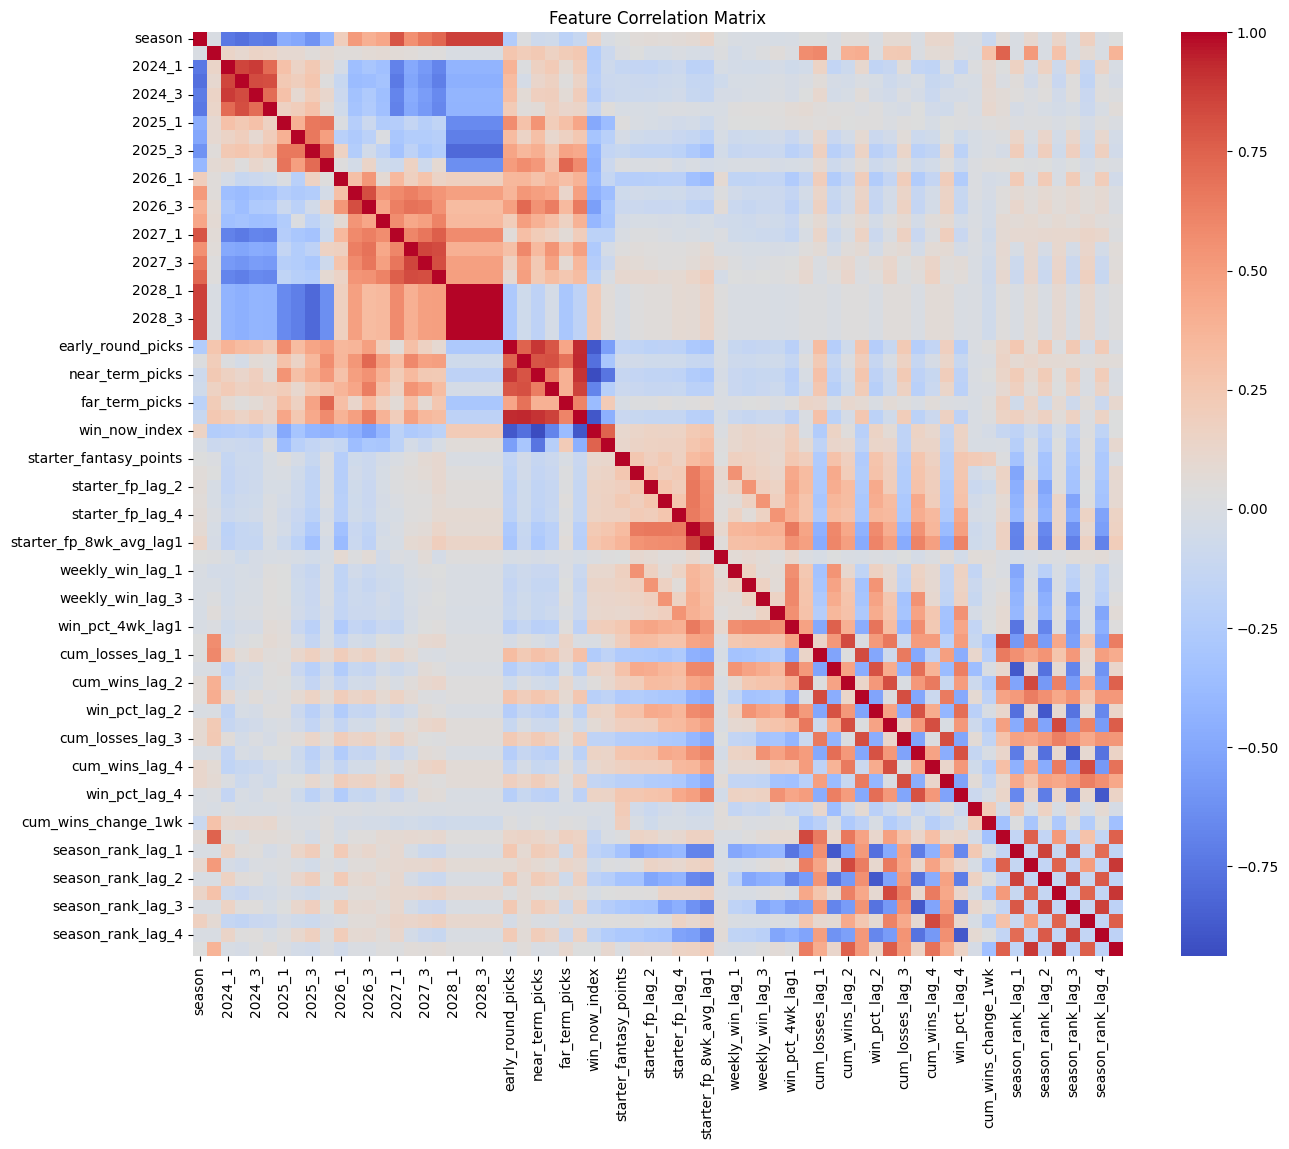

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = train.drop(columns = ['owner']).corr()

# Optional: visualize it
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [298]:
corr_matrix

,season,week,2024_1,2024_2,2024_3,2024_4,2025_1,2025_2,2025_3,2025_4,2026_1,2026_2,2026_3,2026_4,2027_1,2027_2,2027_3,2027_4,2028_1,2028_2,2028_3,2028_4,early_round_picks,late_round_picks,near_term_picks,intermediate_term_picks,far_term_picks,total_future_picks,win_now_index,rebuild_index,starter_fantasy_points,starter_fp_lag_1,starter_fp_lag_2,starter_fp_lag_3,starter_fp_lag_4,starter_fp_4wk_avg_lag1,starter_fp_8wk_avg_lag1,starter_fp_4wk_std_lag1,weekly_win_lag_1,weekly_win_lag_2,weekly_win_lag_3,weekly_win_lag_4,win_pct_4wk_lag1,cum_wins_lag_1,cum_losses_lag_1,win_pct_lag_1,cum_wins_lag_2,cum_losses_lag_2,win_pct_lag_2,cum_wins_lag_3,cum_losses_lag_3,win_pct_lag_3,cum_wins_lag_4,cum_losses_lag_4,win_pct_lag_4,win_pct_change_1wk,cum_wins_change_1wk,cum_points_lag_1,season_rank_lag_1,cum_points_lag_2,season_rank_lag_2,cum_points_lag_3,season_rank_lag_3,cum_points_lag_4,season_rank_lag_4,cum_points_4wk_avg_lag1
season,1.000000e+00,1.346210e-15,-0.741018,-0.776093,-0.722960,-0.740012,-0.465402,-0.504444,-0.606375,-0.394779,0.191639,0.512240,0.399937,0.448274,0.801339,0.556996,0.661875,0.734858,8.660254e-01,8.660254e-01,8.660254e-01,8.660254e-01,-0.243587,0.017741,-0.082381,-0.066132,-0.183791,-0.115803,0.158744,-0.002342,0.030559,0.055454,0.065358,0.055804,0.067790,0.083078,0.132308,0.026978,-0.003845,-0.008057,-0.012685,-0.017790,-0.012183,0.029091,0.030200,-0.000636,0.058127,0.060231,-0.001898,0.086734,0.089775,-0.002814,0.114569,0.118565,-0.003287,0.002861,-0.105521,0.062903,-2.522062e-13,0.103361,-1.459944e-13,0.142088,3.465128e-13,0.179092,6.727979e-14,0.028964
week,1.346210e-15,1.000000e+00,0.141275,0.105004,0.147850,0.134986,0.091484,0.092789,0.049799,0.081201,0.051827,0.049993,0.070359,0.079611,0.061377,0.060341,0.035316,0.041426,1.138720e-16,1.138720e-16,1.138720e-16,1.138720e-16,0.259973,0.208113,0.239814,0.162947,0.215229,0.249519,-0.236638,-0.096591,0.015262,0.027199,-0.020892,-0.019745,0.005724,-0.015123,-0.023530,0.020206,-0.037627,-0.010264,0.019412,0.051181,0.014930,0.571076,0.592861,-0.003352,0.400399,0.414893,0.002414,0.233278,0.241457,0.006435,0.074914,0.077527,0.008214,-0.011748,0.286103,0.743698,1.826103e-16,0.508858,1.156960e-19,0.284062,2.869194e-16,0.076163,-3.009993e-16,0.372885
2024_1,-7.410176e-01,1.412753e-01,1.000000,0.851595,0.886099,0.718689,0.294699,0.144855,0.241821,0.107498,-0.031238,-0.348330,-0.299600,-0.346125,-0.694229,-0.486121,-0.571616,-0.674005,-4.278267e-01,-4.278267e-01,-4.278267e-01,-4.278267e-01,0.382725,0.016122,0.167147,0.225675,0.085978,0.206352,-0.226456,-0.076869,-0.132547,-0.142473,-0.148552,-0.119950,-0.096483,-0.187363,-0.178363,-0.021536,-0.042575,-0.050752,-0.048616,-0.030431,-0.063716,-0.045589,0.157264,-0.147834,-0.087775,0.107644,-0.155557,-0.123403,0.058950,-0.150806,-0.159216,0.007000,-0.139733,0.020621,0.095324,0.029285,1.601017e-01,-0.028492,1.621695e-01,-0.079731,1.547592e-01,-0.132382,1.404490e-01,-0.009011
2024_2,-7.760934e-01,1.050043e-01,0.851595,1.000000,0.829891,0.821439,0.242455,0.190329,0.262444,0.033089,-0.117633,-0.375943,-0.358445,-0.317808,-0.727091,-0.509131,-0.598673,-0.705909,-4.480777e-01,-4.480777e-01,-4.480777e-01,-4.480777e-01,0.328621,-0.033013,0.125082,0.173963,0.041424,0.151194,-0.199606,-0.092884,-0.090437,-0.092134,-0.099012,-0.081349,-0.069899,-0.131460,-0.131735,-0.070853,-0.020725,-0.019657,-0.009711,-0.005499,-0.026892,0.000398,0.056904,-0.026859,-0.044436,0.004409,-0.019528,-0.082312,-0.042445,-0.010971,-0.117628,-0.085499,-0.008686,-0.021888,0.101542,0.005418,5.300295e-02,-0.056046,4.793993e-02,-0.108419,3.977762e-02,-0.156186,3.512855e-02,-0.024605
2024_3,-7.229602e-01,1.478503e-01,0.886099,0.829891,1.000000,0.711963,0.291470,0.098756,0.208658,0.118142,-0.093708,-0.328824,-0.261301,-0.354931,-0.677312,-0.474275,-0.557687,-0.657580,-4.174012e-01,-4.174012e-01,-4.174012e-01,-4.174012e-01,0.309139,0.070937,0.182526,0.194493,0.074532,0.198798,-0.228637,-0.112297,-0.086710,-0.084317,-0.081957,-0.069736,-0.052781,-0.116254,-0.130399,-0.0289

In [299]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assume your dataset is called df_features
# Drop non-numeric or identifier columns if needed
X = train.drop(columns = ['owner', 'starter_fantasy_points']).copy()  # replace with your actual dataframe
import numpy as np

# 1️⃣ Replace inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2️⃣ Drop rows with NaN (or you could fill them if you prefer)
X_clean = X.dropna()

# 3️⃣ Add constant
X_const = add_constant(X_clean)

# 4️⃣ Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Drop constant column
vif_data = vif_data[vif_data["feature"] != "const"].sort_values(by="VIF", ascending=False)

print(vif_data)



                    feature         VIF
33         starter_fp_lag_3         inf
35  starter_fp_4wk_avg_lag1         inf
24         late_round_picks         inf
25          near_term_picks         inf
26  intermediate_term_picks         inf
27           far_term_picks         inf
28       total_future_picks         inf
31         starter_fp_lag_1         inf
32         starter_fp_lag_2         inf
34         starter_fp_lag_4         inf
38         weekly_win_lag_1         inf
22                   2028_4         inf
39         weekly_win_lag_2         inf
40         weekly_win_lag_3         inf
41         weekly_win_lag_4         inf
42         win_pct_4wk_lag1         inf
57         cum_points_lag_1         inf
59         cum_points_lag_2         inf
61         cum_points_lag_3         inf
63         cum_points_lag_4         inf
23        early_round_picks         inf
65  cum_points_4wk_avg_lag1         inf
21                   2028_3         inf
13                   2026_3         inf


/Users/jose/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [300]:
train.columns

Index(['owner', 'season', 'week', '2024_1', '2024_2', '2024_3', '2024_4',
       '2025_1', '2025_2', '2025_3', '2025_4', '2026_1', '2026_2', '2026_3',
       '2026_4', '2027_1', '2027_2', '2027_3', '2027_4', '2028_1', '2028_2',
       '2028_3', '2028_4', 'early_round_picks', 'late_round_picks',
       'near_term_picks', 'intermediate_term_picks', 'far_term_picks',
       'total_future_picks', 'win_now_index', 'rebuild_index',
       'starter_fantasy_points', 'starter_fp_lag_1', 'starter_fp_lag_2',
       'starter_fp_lag_3', 'starter_fp_lag_4', 'starter_fp_4wk_avg_lag1',
       'starter_fp_8wk_avg_lag1', 'starter_fp_4wk_std_lag1',
       'weekly_win_lag_1', 'weekly_win_lag_2', 'weekly_win_lag_3',
       'weekly_win_lag_4', 'win_pct_4wk_lag1', 'cum_wins_lag_1',
       'cum_losses_lag_1', 'win_pct_lag_1', 'cum_wins_lag_2',
       'cum_losses_lag_2', 'win_pct_lag_2', 'cum_wins_lag_3',
       'cum_losses_lag_3', 'win_pct_lag_3', 'cum_wins_lag_4',
       'cum_losses_lag_4', 'win_pct_lag_4', 

In [301]:
train = train[~train['week'].isin([14, 15, 16, 17])]

In [302]:
train[(train['owner'] == 'Jose') & (train['season'].isin([2023]))]

,owner,season,week,2024_1,2024_2,2024_3,2024_4,2025_1,2025_2,2025_3,2025_4,2026_1,2026_2,2026_3,2026_4,2027_1,2027_2,2027_3,2027_4,2028_1,2028_2,2028_3,2028_4,early_round_picks,late_round_picks,near_term_picks,intermediate_term_picks,far_term_picks,total_future_picks,win_now_index,rebuild_index,starter_fantasy_points,starter_fp_lag_1,starter_fp_lag_2,starter_fp_lag_3,starter_fp_lag_4,starter_fp_4wk_avg_lag1,starter_fp_8wk_avg_lag1,starter_fp_4wk_std_lag1,weekly_win_lag_1,weekly_win_lag_2,weekly_win_lag_3,weekly_win_lag_4,win_pct_4wk_lag1,cum_wins_lag_1,cum_losses_lag_1,win_pct_lag_1,cum_wins_lag_2,cum_losses_lag_2,win_pct_lag_2,cum_wins_lag_3,cum_losses_lag_3,win_pct_lag_3,cum_wins_lag_4,cum_losses_lag_4,win_pct_lag_4,win_pct_change_1wk,cum_wins_change_1wk,cum_points_lag_1,season_rank_lag_1,cum_points_lag_2,season_rank_lag_2,cum_points_lag_3,season_rank_lag_3,cum_points_lag_4,season_rank_lag_4,cum_points_4wk_avg_lag1
306,Jose,2023,1,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,5.0,5.0,4.0,14.0,0.117647,0.464286,125.14,NaN,NaN,NaN,NaN,147.710,149.5375,32.886157,NaN,NaN,NaN,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2280.405
307,Jose,2023,2,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,7.0,5.0,4.0,16.0,0.095238,0.406250,127.20,125.14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.500000,0.0,125.14,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,Jose,2023,3,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,7.0,5.0,4.0,16.0,0.095238,0.406250,179.44,127.20,125.14,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,1.0,1.0,0.500000,1.0,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,1.0,252.34,7.0,125.14,3.0,NaN,NaN,NaN,NaN,NaN
309,Jose,2023,4,1.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,8.0,5.0,4.0,17.0,0.086957,0.382353,125.86,179.44,127.20,125.14,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN,2.0,1.0,0.666667,1.0,1.0,0.500000,1.0,0.0,1.000000,NaN,NaN,NaN,0.083333,1.0,431.78,4.0,252.34,7.0,125.14,3.0,NaN,NaN,NaN
310,Jose,2023,5,1.0,3.0,1.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,8.0,6.0,4.0,18.0,0.083333,0.388889,124.32,125.86,179.44,127.20,125.14,139.410,NaN,26.700315,1.0,1.0,0.0,1.0,0.75,3.0,1.0,0.750000,2.0,1.0,0.666667,1.0,1.0,0.500000,1.0,0.0,1.000000,-0.150000,0.0,557.64,3.0,431.78,4.0,252.34,7.0,125.14,3.0,341.725
311,Jose,2023,6,1.0,4.0,1.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0,9.0,8.0,4.0,21.0,0.071429,0.380952,120.06,124.32,125.86,179.44,127.20,139.205,NaN,26.849131,0.0,1.0,1.0,0.0,0.50,3.0,2.0,0.600000,3.0,1.0,0.750000,2.0,1.0,0.666667,1.0,1.0,0.500000,-0.100000,0.0,681.96,5.0,557.64,3.0,431.78,4.0,252.34,7.0,480.930
312,Jose,2023,7,1.0,4.0,1.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0,9.0,8.0,4.0,21.0,0.071429,0.380952,152.96,120.06,124.32,125.86,179.44,137.420,NaN,28.120536,0.0,0.0,1.0,1.0,0.50,3.0,3.0,0.500000,3.0,2.0,0.600000,3.0,1.0,0.750000,2.0,1.0,0.666667,-0.071429,0.0,802.02,6.0,681.96,5.0,557.64,3.0,431.78,4.0,618.350
313,Jose,2023,8,1.0,4.0,1.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0,9.0,8.0,4.0,21.0,0.071429,0.380952,132.26,152.96,120.06,124.32,125.86,130.800,NaN,14.975616,0.0,0.0,0.0,1.0,0.25,3.0,4.0,0.428571,3.0,3.0,0.500000,3.0,2.0,0.600000,3.0,1.0,0.750000,-0.053571,0.0,954.98,7.0,802.02,6.0,681.96,5.0,557.64,3.0,749.150
314,Jose,2023,9,1.0,5.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,10.0,9.0,4.0,23.0,0.064516,0.369565,168.24,132.26,152.96,120.06,124.32,132.400,135.9050,14.609303,0.0,0.0,0.0,0.0,0.00,3.0,5.0,0.375000,3.0,4.0,0.428571,3.0,3.0,0.500000,3.0,2.0,0.600000,0.069444,1.0,1087.24,7.0,954.98,7.0,802.02,6.0,681.96,5.0,881.550
315,Jose,2023,10,1.0,5.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0

In [303]:
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


In [304]:
TARGET = "starter_fantasy_points"

EXCLUDE_COLS = {
    TARGET,
    "owner",
    "season",
    "week"
}

FEATURES = [c for c in train.columns if c not in EXCLUDE_COLS]

train_df = train.dropna(subset=[TARGET]).copy()


In [305]:
LAST_SEASON = train_df["season"].max()

train_data = train_df[train_df["season"] < LAST_SEASON]
val_data   = train_df[train_df["season"] == LAST_SEASON]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_val = val_data[FEATURES]
y_val = val_data[TARGET]


In [306]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),  # wider range
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),  # slightly higher
        "max_depth": trial.suggest_int("max_depth", 3, 10),  # deeper trees
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1,  # use all CPU cores
        "tree_method": "hist"  # faster for larger datasets
    }

    model = XGBRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)

    return mae

In [307]:
# Create study and use all threads for trials
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=-1)  # increase trials and parallelize

print("Best MAE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-12-31 11:55:15,000] A new study created in memory with name: no-name-7bd2a0a9-94de-47a8-b96d-f9fa34c174b8
[I 2025-12-31 11:55:17,125] Trial 0 finished with value: 26.166119793231672 and parameters: {'n_estimators': 315, 'learning_rate': 0.1962838607204894, 'max_depth': 4, 'min_child_weight': 20, 'subsample': 0.7740648139999924, 'colsample_bytree': 0.6444578549237948, 'gamma': 5.296238870158023, 'reg_alpha': 7.729533508925871, 'reg_lambda': 9.508278630857419}. Best is trial 0 with value: 26.166119793231672.
[I 2025-12-31 11:55:17,202] Trial 10 finished with value: 22.60881930307242 and parameters: {'n_estimators': 322, 'learning_rate': 0.011810129510131741, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7951043573546461, 'colsample_bytree': 0.8731543217773317, 'gamma': 4.2727230772999025, 'reg_alpha': 4.744256245369089, 'reg_lambda': 2.433266266404833}. Best is trial 10 with value: 22.60881930307242.
[I 2025-12-31 11:55:18,058] Trial 9 finished with value: 25.189896728515

Best MAE: 22.39455016620343
Best params: {'n_estimators': 300, 'learning_rate': 0.01064243753733236, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.9827038051133099, 'colsample_bytree': 0.9121831708507752, 'gamma': 2.1582646769851213, 'reg_alpha': 0.7827017618781837, 'reg_lambda': 7.9877006630316645}


In [308]:
best_params = study.best_params
best_params.update({
    "objective": "reg:squarederror",
    "random_state": 42
})

final_model = XGBRegressor(**best_params)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9121831708507752, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.1582646769851213,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01064243753733236,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [309]:
train['cum_wins_change_1wk']

0       NaN
1       1.0
2       1.0
3       1.0
4       0.0
5       1.0
6       1.0
7       1.0
8       1.0
9       0.0
10      1.0
11      0.0
12      0.0
17    -11.0
18      1.0
19      0.0
20      1.0
21      1.0
22      1.0
23      0.0
24      1.0
25      1.0
26      1.0
27      1.0
28      0.0
29      0.0
34    -10.0
35      1.0
36      0.0
37      1.0
38      1.0
39      0.0
40      1.0
41      1.0
42      1.0
43      0.0
44      0.0
45      0.0
46      0.0
51      NaN
52      1.0
53      1.0
54      0.0
55      1.0
56      1.0
57      0.0
58      1.0
59      0.0
60      1.0
61      1.0
62      1.0
63      1.0
68    -12.0
69      1.0
70      0.0
71      0.0
72      1.0
73      1.0
74      0.0
75      1.0
76      0.0
77      0.0
78      0.0
79      1.0
80      0.0
85     -7.0
86      1.0
87      0.0
88      1.0
89      0.0
90      1.0
91      1.0
92      1.0
93      0.0
94      1.0
95      0.0
96      0.0
97      0.0
102     NaN
103     1.0
104     0.0
105     0.0
106     0.0
107 

In [310]:
importance = (
    pd.DataFrame({
        "feature": FEATURES,
        "gain": final_model.feature_importances_
    })
    .sort_values("gain", ascending=False)
)

print(importance)


                    feature      gain
53      cum_wins_change_1wk  0.296325
36         weekly_win_lag_2  0.048530
55        season_rank_lag_1  0.035056
57        season_rank_lag_2  0.034255
38         weekly_win_lag_4  0.032859
52       win_pct_change_1wk  0.031691
1                    2024_2  0.019405
3                    2024_4  0.016022
15                   2027_4  0.015858
42            win_pct_lag_1  0.015488
13                   2027_2  0.015096
32  starter_fp_4wk_avg_lag1  0.014590
47         cum_losses_lag_3  0.014224
2                    2024_3  0.014177
51            win_pct_lag_4  0.014040
10                   2026_3  0.013665
50         cum_losses_lag_4  0.013180
8                    2026_1  0.013150
29         starter_fp_lag_2  0.012900
31         starter_fp_lag_4  0.012785
12                   2027_1  0.012056
60         cum_points_lag_4  0.011895
45            win_pct_lag_2  0.011764
33  starter_fp_8wk_avg_lag1  0.011348
23  intermediate_term_picks  0.011325
43          

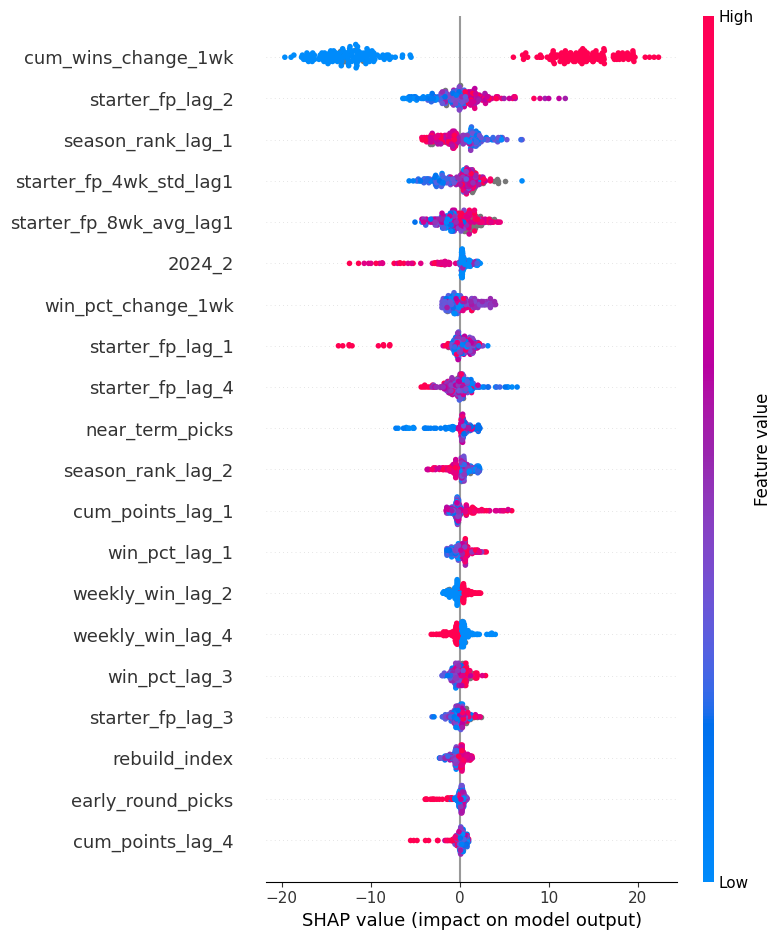

In [311]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [312]:
latest_rows = (
    train_df
    .sort_values(["owner", "season", "week"])
    .groupby("owner", as_index=False)
    .tail(1)
    .copy()
)

PRED_SEASON = latest_rows["season"].max() + 1

latest_rows["season"] = PRED_SEASON
latest_rows["week"] = 1
latest_rows[TARGET] = np.nan

X_pred = latest_rows[FEATURES]

latest_rows["predicted_week1_fp"] = final_model.predict(X_pred)

week1_predictions = (
    latest_rows[["owner", "season", "week", "predicted_week1_fp"]]
    .sort_values("predicted_week1_fp", ascending=False)
)

print(week1_predictions)


       owner  season  week  predicted_week1_fp
403     Lalo    2026     1          170.401138
301    Jacky    2026     1          165.677689
148    Daryl    2026     1          162.134705
199  Devonte    2026     1          158.431595
454     Luis    2026     1          151.665665
352     Jose    2026     1          140.456406
46   Brigido    2026     1          129.225021
97     Bryan    2026     1          128.518021
250      Gio    2026     1          128.439438
505   Marvin    2026     1          128.096146
